# Movimiento Browniano

Paquetes necesarios.

In [85]:
import numpy as np
from random import random
import tqdm
from matplotlib import pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Las siguientes variables son definidas para la simulación de los diferentes movimientos brownianos. 

* $N$ es el número de subintervalos.
* $dt$ es el tamaño del incremento.
* $k$ es el número de trayectorias.
* $t$ es el vector de tiempo

In [54]:
N = 100
dt = 1/N
k = 10000
t = np.arange(0, 1, dt)

Generamos $k$ trayectorias para el movimiento browniano estándar.

In [62]:
B = np.zeros((k, N))
for i in range(k):
    for j in range(1, N):
        B[i,j] = B[i, j-1] + np.sqrt(dt)*np.random.normal()

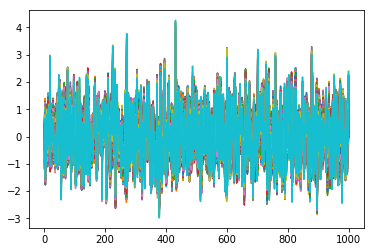

In [73]:
plt.plot(B)
plt.show()

Generamos $k$ trayectorias para el movimiento Browniano Bridge

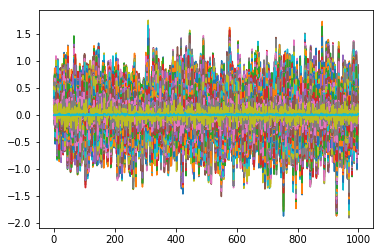

In [75]:
BB = np.zeros((k, N))
for i in range(k):
    for j in range(N):
        BB[i,j] = B[i, j] - t[j]*B[i, N-1]
plt.plot(BB)
plt.show()

#### Análisis vertical
Dadas las propiedades del movimiento browniano, un análisis vertical de cualquier punto de su trayectoria debe resultar en una variable aleatoria con distribución normal.

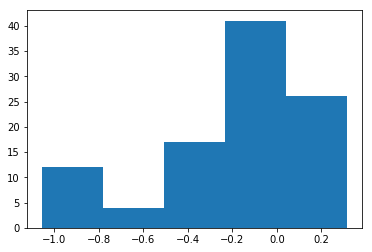

In [69]:
X = B[:][round(N/2)]
plt.hist(X, 5)
plt.show()

## Tests de normalidad

### Test de Jarque-Bera
El test de Jarque-Bera comprueba si los datos de la muestra tienen la asimetría y la curtosis que coinciden con una distribución normal.
El primer valor retornado por el método es el estadístico de prueba, el segundo el p-valor asociado a ella. 
* Un $p$-valor menor a 0.5 no rechaza la hipótesis nula de normalidad.
* Un $p$-valor superior a 0.5 rechaza la hipótesis nula de normalidad.

In [98]:
from scipy import stats
jb = stats.jarque_bera(X)

### Test de Lilliefors
Es una versión modificada del test de Kolmogorov-Smirnov que prueba la normalidad de un conjunto de datos. El primer valor retornado por el método es el estadístico de prueba, el segundo el p-valor asociado a ella.
* Un $p$-valor menor a 0.5 no rechaza la hipótesis nula de normalidad.
* Un $p$-valor superior a 0.5 rechaza la hipótesis nula de normalidad.

In [99]:
from statsmodels.stats.diagnostic import lilliefors
lilie = lilliefors(X)

### Test de Shapiro-Wilk
Prueba la hipótesis nula de que los datos se extrajeron de una distribución normal.
El primer valor retornado por el método es el estadístico de prueba, el segundo el p-valor asociado a ella.
* Un $p$-valor menor a 0.5 no rechaza la hipótesis nula de normalidad.
* Un $p$-valor superior a 0.5 rechaza la hipótesis nula de normalidad.


In [100]:
shapiro = stats.shapiro(X)

In [109]:
df = pd.DataFrame()
df['Jarque Bera'] = [1 if jb[1]<0.05 else 0]
df['Shapiro Wilks'] = [1 if shapiro[1]<0.05 else 0]
df['Lilliefors'] = [1 if lilie[1]<0.05 else 0]
df

,Jarque Bera,Shapiro Wilks,Lilliefors
0,1,1,1
